# L41: Lab 1 - Getting started with kernel tracing - I/O

The goals of this lab are to:

- Introduce you to our experimental environment and DTrace.
- Have you explore user-kernel interactions via system calls and traps.
- Gain experience tracing I/O behaviour in UNIX.
- Develop an intuition about DTrace's probe effect.

You will do this using DTrace to analyse the behaviour of a potted, kernel-intensive block-I/O benchmark.

## Build the benchmark

In [5]:
!make -C io

## Some basic initialization for Python

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

## Some further useful constants used throughout

In [4]:
iterations=4      # Set low for experimentation; consider using 11 "in production"

# `io` benchmark usage information

In [5]:
!io/io-dynamic

usage: io-dynamic -c|-r|-w [-Bdjqsv] [-b buffersize]
    [-n iterations] [-t totalsize] path

Modes (pick one):
    -c              'create mode': create benchmark data file
    -r              'read mode': read() benchmark
    -w              'write mode': write() benchmark

Optional flags:
    -B              Run in bare mode: no preparatory activities
    -d              Set O_DIRECT flag to bypass buffer cache
    -g              Enable getrusage(2) collection
    -j              Output as JSON
    -q              Just run the benchmark, don't print stuff out
    -s              Call fsync() on the file descriptor when complete
    -v              Provide a verbose benchmark description
    -b buffersize   Specify the buffer size (default: 16384)
    -n iterations   Specify the number of times to run (default: 1)
    -t totalsize    Specify the total I/O size (default: 16777216)


# Collect data by running the I/O benchmark across a range of block sizes, capturing JSON output for each blocksize

In [6]:
benchmark_strings = {}
for blocksize in [2**v for v in range(25)]:
    output = !io/io-dynamic -b $blocksize -j -n $iterations -r -v iofile
    benchmark_strings[blocksize] = ' '.join(output)

# Now process to generate easy to access/manipulate arrays of data

In [7]:
bw_samples = {}       # Arrays of bandwidth samples indexed by block size
medians = {}          # Arrays of medians indexed by block size
stds = {}             # Arrays of standard deviations indexed by block size

for blocksize in [2**v for v in range(25)]:
    j = json.loads(benchmark_strings[blocksize])
    samples = list(j["benchmark_samples"])
    bw_samples[blocksize] = list([x["bandwidth"] for x in samples])
    medians[blocksize] = np.median(bw_samples[blocksize])
    stds[blocksize] = np.std(bw_samples[blocksize])

# Some plotting of this data

<ErrorbarContainer object of 3 artists>

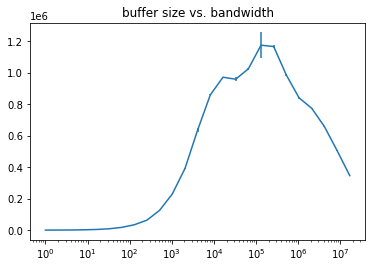

In [8]:
fig1, ax1 = plt.subplots()
ax1.set_title("buffer size vs. bandwidth")

x_coords = []
y_coords = []
errs = []

for x in [2**v for v in range(25)]:
    x_coords.append(x)
    y_coords.append(medians[x])
    errs.append(stds[x])

ax1.set_xscale("log")
ax1.errorbar(x_coords, y_coords, errs)